# Feature Selection Process

## Feature Selection Libraries
  There are a few critical libraries that are used for Feature Selection in general.
  Here is a short summary of those and what they do:
  1. Numpy - Manipulation for multi-dimensional arrays and matrices.
  2. Pandas - Data import and manipulation.
  3. Matplotlib - Data visualization.
  4. Seaborn - Based on matplotlib; plotting statistical graphics.
  5. VarianceThreshold - Used to select features based on their variance.
  This can be useful for reducing the dimensionality of a dataset, or for removing features that are not informative.

  6. Normalize - used to normalize features to have a mean of 0 and a standard deviation of 1. This can be useful for improving the performance of some machine learning algorithms. 

In [7]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import  matplotlib.pyplot as plt 
from sklearn.feature_selection import VarianceThreshold #constant feature
from sklearn.preprocessing import Normalizer, normalize



##### Code Explanation

- `Classes`

    `FeatureSelectionProcess`: As the main class of the notebook consist of these functions :
    - drop_constant_features: In any kind of datasets ther are columns with constant values for all records these columns can not have critical role in Data Analysing, so they are dropped! 
        
    - drop_duplicate_features: In any kind of integrated datasets there columns with different names but refering to the same concept and the values are the same so one of must remain and others will be dropped.
        
    - pearson_correlation : In this function the correlation matrix will be created and a heat map will be ploted for first 100 highly correlated columns and the algorithm for dropping one of the two highly correlated feature is applied too. 

    
    `Outlier Detection` part :
    There are two approaches which has been  considered in the process of project,
        
    - First approach: outliers are detected and removed by Interquartile range method and z-score
        
    - Second approach: the outliers are not removed and are considered in the data. 

In [8]:
class FeatureSelectionProcess:
    def __init__(self , path):
        self.path = path
        self.df = pd.read_csv(path, index_col="SEQN")
            
    def drop_constant_features(self):
        """
        Using VarianceThreshold from Scikit-learn
            The VarianceThreshold from sklearn provides a simple baseline approach to feature selection.
            It removes all features which variance doesn’t meet a certain threshold.
            By default, it removes all zero-variance features, i.e., features that have the same valuein all samples.

        """
        index_values = self.df.index.values

        # print("First 5 rows dataset")
        # print(self.df.head())
        # print("-" * 100)

        print("-" * 100)
        print("\nDimensions of the dataset:")
        print(self.df.shape)
        print("-" * 100)
        columns = self.df.index
        # Create a VarianceThreshold object with the desired threshold
        threshold = 0
        selector = VarianceThreshold(threshold)

        # Fit the selector to our data
        selector.fit(self.df)
        none_constant_indecies =  selector.get_support(indices=True)

        # Filtter the original data to keep only non_constant featues 
        filttered_df = selector.transform(self.df)
        column_names = self.df.columns[none_constant_indecies]
        self.df = pd.DataFrame(filttered_df, columns=column_names)
        self.df.set_index(index_values, inplace=True)
        self.df.index = self.df.index.rename("SEQN")

        print("-" * 100)
        print("\nDimensions of the dataset after constant feature removal:")
        print(self.df.shape)
        print("-" * 100)

        # print("First 5 rows dataset")
        # print(self.df.head())
        # # print("-" * 100)

    def drop_duplicate_features(self):
        # create an empty dictionary, where we will store 
        # the groups of duplicates
        duplicated_feat_pairs = {}

        # create an empty list to collect features
        # that were found to be duplicated
        _duplicated_feat = []

        print("-" * 100)
        print("\nDimensions of the dataset:")
        print(self.df.shape)
        print("-" * 100)

        # iterate over every feature in our dataset:
        for i in range(0, len(self.df.columns)):
            
            # choose 1 feature:
            feat_1 = self.df.columns[i]
            
            # check if this feature has already been identified
            # as a duplicate of another one. If it was, it should be stored in
            # our _duplicated_feat list.
            
            # If this feature was already identified as a duplicate, we skip it, if
            # it has not yet been identified as a duplicate, then we proceed:
            if feat_1 not in _duplicated_feat:
            
                # create an empty list as an entry for this feature in the dictionary:
                duplicated_feat_pairs[feat_1] = []

                # now, iterate over the remaining features of the dataset:
                for feat_2 in self.df.columns[i + 1:]:

                    # check if this second feature is identical to the first one
                    if self.df[feat_1].equals(self.df[feat_2]):

                        # if it is identical, append it to the list in the dictionary
                        duplicated_feat_pairs[feat_1].append(feat_2)
                        
                        # and append it to our monitor list for duplicated variables
                        _duplicated_feat.append(feat_2)
                        
                        # done!
        self.df = self.df[duplicated_feat_pairs.keys()]

        print("-" * 100)
        print(" Number of Duplicate features: %d" %len(_duplicated_feat))
        print("-" * 100)
        print("\nDimensions of the dataset:")
        print(self.df.shape)
        print("-" * 100)


    def pearson_correlation(self, threshold=0.5):
        """
            Visualising correlated features:
                A correlation matrix will be made, which check the 
                correlation of all features (that is, for all possible feature combinations)
                and then visualise the correlation matrix using a heatmap
            Note:
                The default correlation method of pandas.corr is pearson
        """

        print("-" * 100)
        correlation_matrix = self.df.corr(method="pearson")
        print(correlation_matrix)
        print("-" * 100)


        # Heatmap with  seaborn
        correlation_heatmap = sns.diverging_palette(100, 15, as_cmap=True)
        fig , ax = plt.subplots()
        plt.rcParams["font.size"] = 14
        fig.set_size_inches(15,15)
        sns.heatmap(correlation_matrix, cmap=correlation_heatmap)

        ####
        top_100_correlated_features = correlation_matrix.nlargest(100,["MCQ160L", "MCQ220"])
        top_100_column_names = top_100_correlated_features.index.to_list() 
        
        def highly_correlated_features(correlation_matrix):
            correlation_matrix_coppy = correlation_matrix
            highly_correlated_features = set()
            n=len(correlation_matrix_coppy) ** 2
            mask = ~correlation_matrix_coppy.isna()
            # Set the lower triangle of the correlation matrix to NaN
            lower_triangle = np.tril(mask)
            correlation_matrix_coppy.mask(lower_triangle, inplace=True)
            correlations = correlation_matrix_coppy.abs().unstack().sort_values(ascending=False)

            sorted_correlations = correlations.dropna()[:n]

            for attr1, attr2 in sorted_correlations.index:
                if sorted_correlations[attr1, attr2] > threshold:
                    highly_correlated_features.add(attr1)
            
            return highly_correlated_features
        
        highly_correlated_feature = highly_correlated_features(correlation_matrix)
        ###
        
        
        self.df = self.df[list(highly_correlated_feature)]
        self.df.to_csv("/home/asma-rashidian/Documents/DrRahmani_projects/project1/data/result/pearson_correlated.csv")
        print("-" * 100)
        print(len(highly_correlated_feature))
        print(highly_correlated_feature)
        print("-" * 100)
      
        print("-" * 100)
        print(" 100 highly correlated features:")
        print(top_100_column_names)
        print("-" * 100)


        print("-" * 100)
        print("\n Output dataset base on correlation threshold:")
        print(self.df.shape)
        
    def z_score_method(self):
            # Calculate the z score for each data point
            z_scores = np.abs(self.df - self.df.mean()) / self.df.std()

            # Define the threshold for outliers
            threshold = 3

            # Identify the outliers
            outliers = self.df[z_scores >= threshold]

            # Remove the outliers from the dataset
            self.df = self.df[z_scores < threshold]
            
            print("-" * 100)
            print("\n Dimensions of the dataset:")
            print(self.df.shape)
            print("-" * 100)

            
    def interquartle_range_method(self, threshold=3):

        Q1 = self.df.quantile(0.25)
        Q3 = self.df.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((self.df < (Q1 - 1.5 * IQR)) | (self.df > (Q3 + 1.5 * IQR))).sum(axis=0) / len(self.df) * 100
        columns_to_drop_outliers = outliers[outliers > 30].index
        self.df = self.df.drop(columns=columns_to_drop_outliers)

 
        print("-" * 100)
        print("\nDimensions of the dataset after IQR outlier detection:")
        print(self.df.shape)
        print("-" * 100)


#### Drop Constant Features
Constant features are those that show the same value, just one value, for all the observations of the dataset. In other words, the same value for all the rows of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target.
Identifying and removing constant features is an easy first step towards feature selection and more easily interpretable machine learning models.
To identify constant features, we can use the VarianceThreshold from Scikit-learn,

** If using the VarianceThreshold, all our variables need to be numerical **

In [9]:
integrated_data_path = '/home/asma-rashidian/Documents/DrRahmani_projects/project1/data/result/integrated_data.csv'
feature_selection_process = FeatureSelectionProcess(integrated_data_path)
feature_selection_process.drop_constant_features()


----------------------------------------------------------------------------------------------------

Dimensions of the dataset:
(10175, 376)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Dimensions of the dataset after constant feature removal:
(10175, 372)
----------------------------------------------------------------------------------------------------


#### Duplicate Features 
Often datasets contain duplicated features, that is, features that despite having different names, are identical.
Identifying and removing duplicated, and therefore redundant features, is an easy first step towards feature selection and more interpretable machine learning models.

`Note`:  Finding duplicated features can be a computationally costly operation in Python, therefore depending on the size of your dataset, you might not always be able to do it.

This method that I describe here to find duplicated features works for both numerical and categorical variables.

In [10]:
feature_selection_process.drop_duplicate_features()

----------------------------------------------------------------------------------------------------

Dimensions of the dataset:
(10175, 372)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
 Number of Duplicate features: 3
----------------------------------------------------------------------------------------------------

Dimensions of the dataset:
(10175, 369)
----------------------------------------------------------------------------------------------------


#### Pearson Correlation
Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis:

`Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other`.



----------------------------------------------------------------------------------------------------
           BMDAVSAD  BMDSTATS   BMXARMC   BMXARML    BMXBMI     BMXHT  \
BMDAVSAD   1.000000  0.008423  0.604606  0.266138  0.752741  0.227022   
BMDSTATS   0.008423  1.000000  0.061719  0.059508  0.082383 -0.020025   
BMXARMC    0.604606  0.061719  1.000000  0.830861  0.809875  0.620018   
BMXARML    0.266138  0.059508  0.830861  1.000000  0.472233  0.683308   
BMXBMI     0.752741  0.082383  0.809875  0.472233  1.000000  0.508466   
...             ...       ...       ...       ...       ...       ...   
URXUMA     0.065843  0.016338  0.053825  0.064668  0.053922  0.049226   
URXVOL1    0.020901 -0.051218  0.127969  0.154320  0.062872  0.163426   
WTDR2D     0.085355 -0.020405  0.173223  0.180489  0.117343  0.156047   
WTDRD1     0.114270 -0.045441  0.245602  0.259560  0.167150  0.234349   
WTSH2YR.x  0.132748 -0.009277  0.290283  0.297646  0.216567  0.307988   

             BMXLEG   

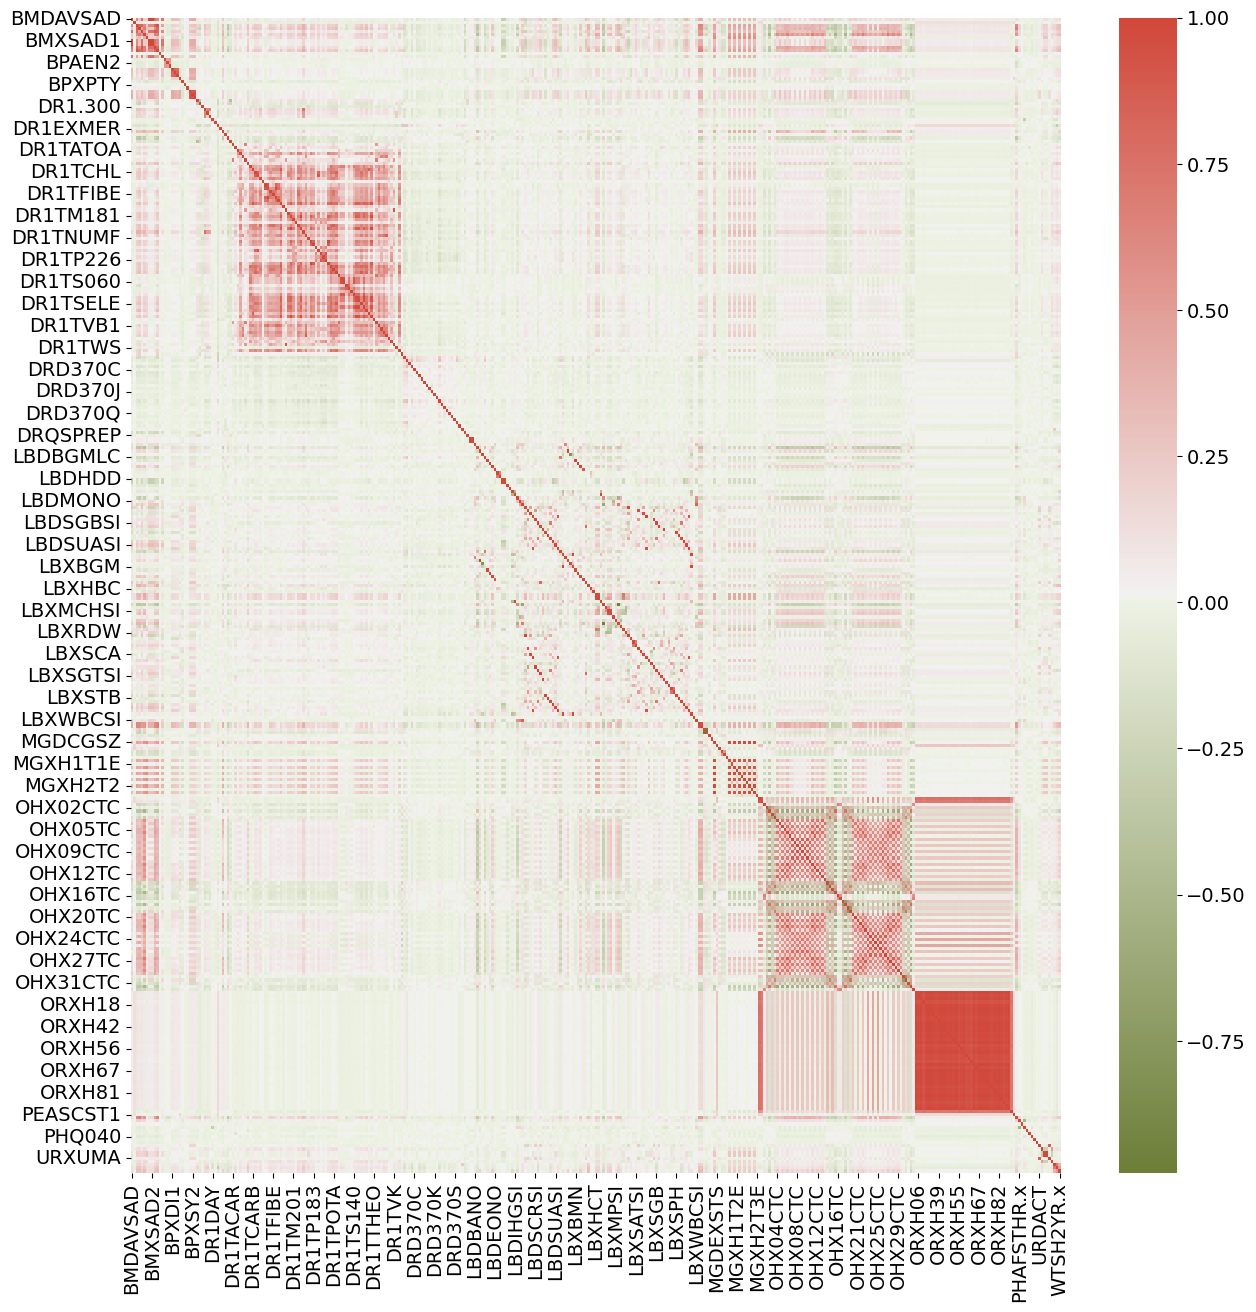

In [11]:
feature_selection_process.pearson_correlation()

In [12]:
feature_selection_process.interquartle_range_method()

----------------------------------------------------------------------------------------------------

Dimensions of the dataset after IQR outlier detection:
(10175, 202)
----------------------------------------------------------------------------------------------------
